In [94]:
# Load libraries
import pandas as pd
import numpy as np
import json
import tensorflow as tf
from sklearn import model_selection
import networkx as nx

import sys
import os
import torch
import argparse
import random


import stellargraph as sg
from stellargraph.mapper import GraphSAGELinkGenerator, GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UnsupervisedSampler


#Hindsage libraries
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('yelp_academic_dataset_review.json') as json_file:      
    data = json_file.readlines()
    # this line below may take at least 8-10 minutes of processing for 4-5 million rows. It converts all strings in list to actual json objects. 
    data = list(map(json.loads, data)) 
reviews_data = pd.DataFrame(data)

In [3]:
with open('yelp_academic_dataset_user.json') as json_file_1:      
    data_1 = json_file_1.readlines()
    # this line below may take at least 8-10 minutes of processing for 4-5 million rows. It converts all strings in list to actual json objects. 
    data_1 = list(map(json.loads, data_1)) 

user_data = pd.DataFrame(data_1)

In [4]:
with open('yelp_academic_dataset_business.json') as json_file_2:      
    data_2 = json_file_2.readlines()
    # this line below may take at least 8-10 minutes of processing for 4-5 million rows. It converts all strings in list to actual json objects. 
    data_2 = list(map(json.loads, data_2)) 

business_data = pd.DataFrame(data_2)

In [5]:
business_dataset = business_data[business_data.state == 'IL']

In [6]:
business_dataset = business_dataset.loc[(business_dataset['review_count'] >= 15)]

In [7]:
business_dataset.index = pd.Series(range(0,717))

In [8]:
business_dataset["category"] = 0

In [9]:
node_data_business = pd.DataFrame(business_dataset)
feature_names_business = ['business_id','stars', 'category']
node_features_business = pd.DataFrame(node_data_business[feature_names_business],index = node_data_business.index)
node_features_business.index =  node_data_business["business_id"]
node_features_business = node_features_business.drop(columns=['business_id'])
node_features_business[0:]

,stars,category
business_id,,
UiyjUa8CQmygujhe-ZYlsw,3.0,0
-LfTBo0oa_uD454ScEW2XA,3.0,0
R32Yh0XxxanldkIp11fuRg,3.5,0
-1TUzO4XCmOeqi9eAGeDWA,4.5,0
WO2nNar_wIQ3fIAfF3MM1Q,4.0,0
...,...,...
ldKrUirpZZ6JDnNwOwLpvw,3.0,0
KCQNEIvtU48Mh07uS-_Gvw,2.5,0
nh1-ax9wPNCqskcJYIWogg,2.5,0


In [10]:
# Data cleaning for reviews dataset

In [11]:
business_id_array = business_dataset['business_id'].values

In [12]:
reviews_dataset = reviews_data.loc[reviews_data['business_id'].isin(business_id_array)]

In [13]:
reviews_dataset["category"] = 1

<ipython-input-13-ba30f82d583b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_dataset["category"] = 1


In [14]:
reviews_dataset.index = pd.Series(range(0,39138))
node_data_review = pd.DataFrame(reviews_dataset)
feature_names_reviews = ['review_id','stars', 'category']
node_features_reviews = pd.DataFrame(node_data_review[feature_names_reviews],index = node_data_review.index)
node_features_reviews.index = node_data_review['review_id']
node_features_reviews = node_features_reviews.drop(columns = ['review_id'])
node_features_reviews[0:]

,stars,category
review_id,,
qWHp2l2lysENZObh6MAulA,5.0,1
n2BEHit2SwqsRo6jlTagUA,2.0,1
m4AXzV9l14iFBd9DRdM82w,1.0,1
A-yKlSLEQQcoHR5q2lCyHg,5.0,1
asLnux3k2yqoVjcJcLuF0g,4.0,1
...,...,...
57cCUwZm4lsHum8aENC6Kg,1.0,1
ZnE93UGlk29kX0dfwMOGNw,5.0,1
fGgMD8npNcGyx_Fr91m_Dg,4.0,1


In [15]:
#Data cleaning for user dataset

In [16]:
user_id_array = reviews_dataset['user_id'].values

In [17]:
user_dataset = user_data.loc[user_data['user_id'].isin(user_id_array)]

In [18]:
user_dataset["category"] = 2
user_dataset["stars"] = 0

<ipython-input-18-cb744e0f1c93>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_dataset["category"] = 2
<ipython-input-18-cb744e0f1c93>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_dataset["stars"] = 0


In [19]:
user_dataset.index = pd.Series(range(0,14664))
node_data_user = pd.DataFrame(user_dataset)
feature_names_user = ['user_id','stars', 'category']
node_features_user = pd.DataFrame(node_data_user[feature_names_user],index = node_data_user.index)
node_features_user.index = node_features_user['user_id']

# duplicate_indices = ['Ig_kYiH5Jr3BmPy9QiUhcA','Ya5Rf9V_rt0CF5uSllo0-g','vrAMHb0pzDko9_kxOZMgVg','wlsl5O1f8AnOYg1S53bRhw']
# dup_1 = node_features_user[ node_features_user['user_id'] == 'Ig_kYiH5Jr3BmPy9QiUhcA' ].index 
# dup_2 = node_features_user[ node_features_user['user_id'] == 'Ya5Rf9V_rt0CF5uSllo0-g' ].index
# dup_3 = node_features_user[ node_features_user['user_id'] == 'vrAMHb0pzDko9_kxOZMgVg' ].index
# dup_4 = node_features_user[ node_features_user['user_id'] == 'wlsl5O1f8AnOYg1S53bRhw' ].index

  
# # drop these row indexes 
# # from dataFrame 
# node_features_user.drop(dup_1, inplace = True)
# node_features_user.drop(dup_2, inplace = True)
# node_features_user.drop(dup_3, inplace = True)
# node_features_user.drop(dup_4, inplace = True)


node_features_user = node_features_user.drop(columns = ['user_id'])
node_features_user[0:]

,stars,category
user_id,,
fcNU65OaCj7slBJ60VSQgw,0,2
4mjnkd8oJVCfBKN3i4rB-g,0,2
ZdYHJ-hctaaDeH1CpP7-EA,0,2
JWgti_adPZywG9SKUbnB-w,0,2
PIzmdHF7p9GwXhwt3b3JxQ,0,2
...,...,...
YfVGrr7SqPI1NY-mx9jfUw,0,2
lcd1uiaw4sZd7wGxpHbd0w,0,2
woRHA_rBPcg-KU8EJDG1Ig,0,2


In [20]:
#Hindsage
batch_size = 200
epochs = 20
# Use 70% of edges for training, the rest for testing:
train_size = 0.7
test_size = 0.3

In [21]:
review_business_edges = pd.DataFrame({"source": reviews_dataset['review_id'],
                                      "target": reviews_dataset['business_id'],
                                      "weight":reviews_dataset['stars']})

review_user_edges = pd.DataFrame({"source": reviews_dataset['user_id'],
                                      "target": reviews_dataset['review_id'],
                                      "weight":reviews_dataset['stars']})

user_business_edges = pd.DataFrame({"source": reviews_dataset['business_id'],
                                      "target": reviews_dataset['user_id'],
                                      "weight":reviews_dataset['stars']})
user_business_edges

,source,target,weight
0,ZlCSsWS07JulSBIQlrbF5w,5lb0POg2t-AkMFx6603cYQ,5.0
1,2qLOnQtWSlTOtkfEFyWScg,abdw-Nf5xxWdi5wmUO7UYg,2.0
2,9A1C1f0m4nQltQrOOTl-Kw,6X0i-oGUbh5DZdTHzFuKfg,1.0
3,VHsNB3pdGVcRgs6C3jt6Zg,Yximlvn0cfb3yVDaLuXDxw,5.0
4,Ah4i15g8Ow_zphzcpulTxQ,Cz8l7JQ2I_RhtK0BosH-7Q,4.0
...,...,...,...
39133,IJ_1Hcuh89ETzDFK6pXOpg,R_VuCujoBAOFpUuqIYC_Gg,1.0
39134,PBmfdx-tC2D54FI3HtcKww,ViqyzZgObMSOwWBoQbLjSg,5.0
39135,dn9lwYUxmhs_mLKPu7L25Q,Nl9ouJ9EqcNCX7gdPw9ZCw,4.0
39136,l4x5FFzfiCFrGN0S-uZbBQ,x4XrrBXlKABQCyv1AMHHrA,4.0


In [22]:
# edges.index = pd.Series(range(0,117414))
# edges

In [23]:
edges_train, edges_test = model_selection.train_test_split(
    user_business_edges, train_size=train_size, test_size=test_size
)

edgelist_train = list(edges_train[["source", "target"]].itertuples(index=False))
edgelist_test = list(edges_test[["source", "target"]].itertuples(index=False))

labels_train = edges_train["weight"]
labels_test = edges_test["weight"]

In [24]:
num_samples = [8, 4]

In [25]:
#To find the duplicates in features data frame
# pics = features.index.unique()
# len(pics)
# for i in (pics):
#     sub = features[features.index==i]
#     if len(sub)>1:
#         print(sub)  

In [26]:
features = pd.concat([node_features_reviews,node_features_business,node_features_user])

In [27]:
G = sg.StellarGraph(nodes = {"user": node_features_user,"business": node_features_business}, edges = user_business_edges)

In [28]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 15381, Edges: 39138

 Node types:
  user: [14664]
    Features: float32 vector, length 2
    Edge types: user-default->business
  business: [717]
    Features: float32 vector, length 2
    Edge types: business-default->user

 Edge types:
    business-default->user: [39138]
        Weights: range=[1, 5], mean=3.58421, std=1.4602
        Features: none


In [29]:
# generator_G = GraphSAGELinkGenerator(G, batch_size, num_samples)
# train_gen_G = generator.flow(edgelist_train, labels_train, shuffle=True)
# test_gen_G = generator.flow(edgelist_test, labels_test)

In [30]:
nodes_user = list(node_features_user.index)
nodes_business = list(node_features_business.index)
nodes = nodes_user + nodes_business
number_of_walks = 1
length = 5


In [31]:
generator = sg.mapper.HinSAGELinkGenerator(
    G, batch_size, num_samples , head_node_types = ('business','user')
)

In [32]:
train_gen = generator.flow(edgelist_train, labels_train, shuffle=True)

In [33]:
test_gen = generator.flow(edgelist_test, labels_test)

In [34]:
generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))

[('business', [2]),
 ('user', [3]),
 ('user', [4]),
 ('business', [5]),
 ('business', []),
 ('user', [])]

In [35]:
generator.schema.schema

{'user': [EdgeType(n1='user', rel='default', n2='business')],
 'business': [EdgeType(n1='business', rel='default', n2='user')]}

In [36]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.0
)

In [37]:
x_inp, x_out = hinsage.in_out_tensors()

In [38]:
score_prediction = link_regression(edge_embedding_method="concat")(x_out)

link_regression: using 'concat' method to combine node embeddings into edge embeddings


In [39]:
x_inp

[<KerasTensor: shape=(None, 1, 2) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 1, 2) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 8, 2) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 8, 2) dtype=float32 (created by layer 'input_4')>,
 <KerasTensor: shape=(None, 32, 2) dtype=float32 (created by layer 'input_5')>,
 <KerasTensor: shape=(None, 32, 2) dtype=float32 (created by layer 'input_6')>]

In [40]:
x_out

[<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'lambda')>,
 <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'lambda')>]

In [41]:
score_prediction

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'reshape_8')>

In [43]:
import tensorflow.keras.backend as K


def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8, 2)]       0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 32, 2)]      0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 32, 2)]      0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1, 2)]       0                                            
______________________________________________________________________________________________

In [45]:
num_workers = 4

In [46]:
test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

59/59 [==============================] - 24s 241ms/step - loss: 17.3959 - root_mean_square_error: 4.1698 - mean_absolute_error: 3.90778s - loss: 17.0939 - root_mean_square_error: 4.1335 - mean_absolute_error: 3.867 - ETA: 7s - loss: 17.1419 - root_mean_square_error: 4.1393 - mean_absolute_error: 3.8 - ETA: 6s - loss: 17.2216 - root_mean_square_error: 4.1489 - mean_absolute_err - ETA: 3s - loss: 17.3128 - root_mean_square_error: 4.1599 - mean_absolute_error: 3.89 - ETA: 3s - loss: 17.3189 - root_mean_square_error: 4.1606 - mean_abs
Untrained model's Test Evaluation:
	loss: 17.4351
	root_mean_square_error: 4.1735
	mean_absolute_error: 3.9119


In [47]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers,
)

Epoch 1/20
137/137 [==============================] - 37s 156ms/step - loss: 2.5306 - root_mean_square_error: 1.5382 - mean_absolute_error: 1.3492 - val_loss: 1.8363 - val_root_mean_square_error: 1.3548 - val_mean_absolute_error: 1.1752s - loss: 5.9008 - root_mean_square_error: 2.3190 - mean_absolute - ETA: 25s - loss: 4.1235 - root_mean_square_error: 1.9195 - mean  - ETA: 1s - loss: 2.6046 - root_mean_square_error: 1.5580 - mean_absolute_error: 
Epoch 2/20
137/137 [==============================] - 15s 105ms/step - loss: 1.7094 - root_mean_square_error: 1.3061 - mean_absolute_error: 1.0781 - val_loss: 1.6878 - val_root_mean_square_error: 1.2983 - val_mean_absolute_error: 1.0598ean_square_error: 1.3171 - mean_absolute_e - ETA: 7s - loss: 1.7322 - root_mean_square_error: 1.3147 - mea - ETA: 6s - loss: 1.7285 - root_mean_square_error: 1.3134 - ETA: 4s - loss: 1.7201 - root_mean_square_e - ETA: 2s - loss: 1.7219 - root_mean_square
Epoch 3/20
137/137 [==============================] - 15s 

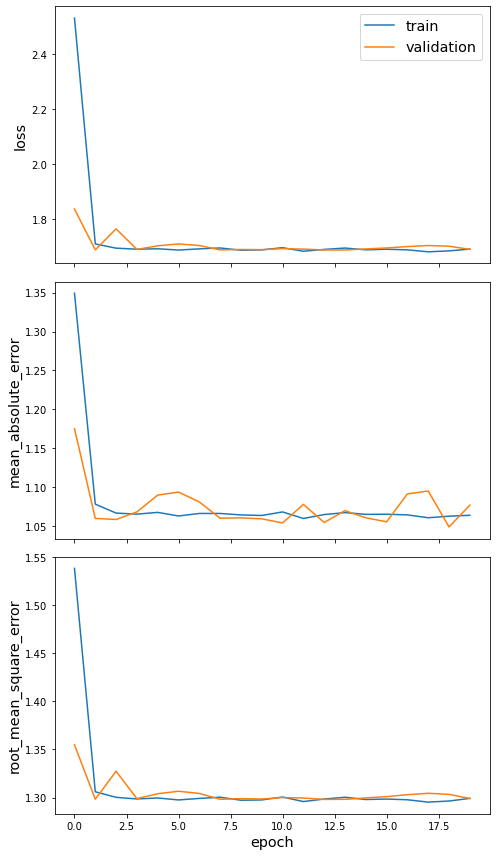

In [48]:
sg.utils.plot_history(history)

In [49]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

59/59 [==============================] - 4s 55ms/step - loss: 1.6892 - root_mean_square_error: 1.2990 - mean_absolute_error: 1.0761
Test Evaluation:
	loss: 1.6892
	root_mean_square_error: 1.2990
	mean_absolute_error: 1.0761


In [50]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model.predict(test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  1.463703040241648
	mean_absolute_error =  1.2744868861169023

Model Test set metrics:
	root_mean_square_error =  1.300184869129778
	mean_absolute_error =  1.076975766742601


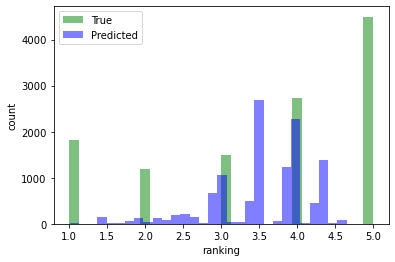

In [51]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()

In [52]:
#Implementation of SVM

In [53]:
from sklearn import svm

In [54]:
reviews_dataset

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,category
0,qWHp2l2lysENZObh6MAulA,5lb0POg2t-AkMFx6603cYQ,ZlCSsWS07JulSBIQlrbF5w,5.0,1,0,0,Called for a 5:15 morning reservation. The dri...,2015-05-26 10:36:47,1
1,n2BEHit2SwqsRo6jlTagUA,abdw-Nf5xxWdi5wmUO7UYg,2qLOnQtWSlTOtkfEFyWScg,2.0,2,0,0,"There are good things, and bad things about th...",2013-04-10 19:26:54,1
2,m4AXzV9l14iFBd9DRdM82w,6X0i-oGUbh5DZdTHzFuKfg,9A1C1f0m4nQltQrOOTl-Kw,1.0,11,1,0,The building is lovely. The remodel after But...,2013-12-07 02:26:13,1
3,A-yKlSLEQQcoHR5q2lCyHg,Yximlvn0cfb3yVDaLuXDxw,VHsNB3pdGVcRgs6C3jt6Zg,5.0,1,0,0,LOVE LOVE LOVE this place! I'm a bit of a suck...,2013-08-03 19:59:56,1
4,asLnux3k2yqoVjcJcLuF0g,Cz8l7JQ2I_RhtK0BosH-7Q,Ah4i15g8Ow_zphzcpulTxQ,4.0,0,0,0,The bread company is perfect for lunch. The pr...,2015-12-05 05:38:55,1
...,...,...,...,...,...,...,...,...,...,...
39133,57cCUwZm4lsHum8aENC6Kg,R_VuCujoBAOFpUuqIYC_Gg,IJ_1Hcuh89ETzDFK6pXOpg,1.0,0,0,0,Came here to do my laundry at 8:00 on a Sunday...,2019-12-09 02:38:18,1
39134,ZnE93UGlk29kX0dfwMOGNw,ViqyzZgObMSOwWBoQbLjSg,PBmfdx-tC2D54FI3HtcKww,5.0,0,0,0,Have always loved The Ribeye. The best salad ...,2019-11-26 00:20:28,1
39135,fGgMD8npNcGyx_Fr91m_Dg,Nl9ouJ9EqcNCX7gdPw9ZCw,dn9lwYUxmhs_mLKPu7L25Q,4.0,0,0,0,The appetizers and my seared tuna were awesome!,2014-02-17 12:39:26,1
39136,flX4YICNgGSs2QriJ2CgRw,x4XrrBXlKABQCyv1AMHHrA,l4x5FFzfiCFrGN0S-uZbBQ,4.0,0,0,0,"Came to dinner on a Tuesday night and, granted...",2019-10-23 15:04:57,1


In [55]:
user_dataset

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,category,stars
0,fcNU65OaCj7slBJ60VSQgw,Steven,1204,2007-07-08 16:56:40,4907,2674,2718,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2016","T-CVPEYAAJFWGzXaxSt8eg, zyhHd6AeavKVdOAXAPz-DQ...",89,...,6,4,79,141,183,183,57,12,2,0
1,4mjnkd8oJVCfBKN3i4rB-g,Tricia,1247,2008-11-27 02:24:47,3967,2631,2491,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2018","RO3vznPVVw5NWcgfP3k17A, azPMZoWkxdyjpnFul3aBQw...",141,...,15,10,127,236,227,227,124,102,2,0
2,ZdYHJ-hctaaDeH1CpP7-EA,Colleen,266,2009-08-08 16:46:46,491,103,152,"2010,2011,2012,2013,2014","ouODopBKF3AqfCkuQEnrDg, QowYhZNL0T3UOi1FLG5VYQ...",11,...,3,0,14,16,17,17,5,3,2,0
3,JWgti_adPZywG9SKUbnB-w,Sarah,141,2007-11-12 02:56:43,227,76,42,2015,"-X2qJ65I4Gz3UznpJqqS7Q, XrrXU5whFrQo_3wpiKhpaw...",1,...,0,0,5,3,5,5,2,1,2,0
4,PIzmdHF7p9GwXhwt3b3JxQ,Sasuke,112,2008-07-15 19:06:06,154,57,35,,"wPkrThYsvs-pii7Ac1Hk9w, nO4bSABjYmR3MVvVjC0EeQ...",7,...,0,0,3,4,1,1,4,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14659,YfVGrr7SqPI1NY-mx9jfUw,Liz,2,2018-03-19 22:18:34,0,0,0,,None,0,...,0,0,0,0,0,0,0,0,2,0
14660,lcd1uiaw4sZd7wGxpHbd0w,Lisa,3,2014-08-03 22:23:27,4,1,0,,None,0,...,0,0,0,0,0,0,0,0,2,0
14661,woRHA_rBPcg-KU8EJDG1Ig,Gloria,17,2016-03-05 03:55:54,0,0,0,,None,0,...,0,0,0,0,0,0,0,0,2,0
14662,3Xop9LVQDOWIVjFRj07QTw,Boom Your Place Sucks,2,2014-10-09 07:16:34,5,5,2,,None,0,...,0,0,0,0,0,0,0,0,2,0


In [56]:
business_dataset

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,category
0,UiyjUa8CQmygujhe-ZYlsw,Movers 4 Less Inc,,Champaign,IL,61822,40.127030,-88.241699,3.0,15,1,"{'BusinessAcceptsCreditCards': 'True', 'Busine...","Home Services, Movers","{'Monday': '8:0-20:0', 'Tuesday': '8:0-20:0', ...",0
1,-LfTBo0oa_uD454ScEW2XA,Merry Ann's Diner,1 E Main St,Champaign,IL,61820,40.118133,-88.242900,3.0,47,0,"{'RestaurantsDelivery': 'True', 'WiFi': 'u'fre...","Restaurants, Diners, Sandwiches, Breakfast & B...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",0
2,R32Yh0XxxanldkIp11fuRg,BoBo's BBQ,1511 W Springfield Ave,Champaign,IL,61821,40.112515,-88.271575,3.5,45,1,"{'RestaurantsAttire': 'u'casual'', 'Restaurant...","Hot Dogs, Restaurants, Barbeque","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",0
3,-1TUzO4XCmOeqi9eAGeDWA,Beaumont Tire & Auto Repair,1202 W Bloomington Rd,Champaign,IL,61821,40.136060,-88.266079,4.5,15,1,{'BusinessAcceptsCreditCards': 'True'},"Auto Repair, Automotive, Tires","{'Monday': '8:0-17:30', 'Tuesday': '8:0-17:30'...",0
4,WO2nNar_wIQ3fIAfF3MM1Q,Exile on Main Street,"116 N Chestnut St, Ste 120",Champaign,IL,61820,40.116715,-88.240606,4.0,24,1,"{'BusinessAcceptsBitcoin': 'False', 'BusinessP...","Newspapers & Magazines, Books, Mags, Music & V...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,ldKrUirpZZ6JDnNwOwLpvw,Ichiban Buffet,105 N Mattis Ave,Champaign,IL,61821,40.117048,-88.278364,3.0,35,0,"{'GoodForKids': 'True', 'RestaurantsReservatio...","Sushi Bars, Chinese, Buffets, Restaurants","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3...",0
713,KCQNEIvtU48Mh07uS-_Gvw,Taco Bell,1003 University,Urbana,IL,61801,40.116340,-88.220850,2.5,34,1,"{'RestaurantsPriceRange2': '1', 'GoodForKids':...","Fast Food, Restaurants, Tex-Mex, Mexican, Tacos","{'Monday': '7:0-3:0', 'Tuesday': '7:0-3:0', 'W...",0
714,nh1-ax9wPNCqskcJYIWogg,Buttitta's,1201 S Neil St,Champaign,IL,61820,40.103246,-88.244236,2.5,27,0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Italian, Restaurants",None,0
715,DTxj39kZVe3NUscJoPYUYA,Car-X Tire & Auto,2216 S Neil St,Champaign,IL,61820,40.086725,-88.246067,3.0,22,1,{'BusinessAcceptsCreditCards': 'True'},"Oil Change Stations, Tires, Automotive, Auto R...","{'Monday': '7:30-18:0', 'Tuesday': '7:30-18:0'...",0


In [57]:
svm_features_reviews = ['review_id','stars', 'useful','funny','cool']
svm_reviews = pd.DataFrame(reviews_dataset[svm_features_reviews])
svm_reviews.index = svm_reviews['review_id']
svm_reviews = svm_reviews.drop(columns = ['review_id'])
svm_reviews[0:]

,stars,useful,funny,cool
review_id,,,,
qWHp2l2lysENZObh6MAulA,5.0,1,0,0
n2BEHit2SwqsRo6jlTagUA,2.0,2,0,0
m4AXzV9l14iFBd9DRdM82w,1.0,11,1,0
A-yKlSLEQQcoHR5q2lCyHg,5.0,1,0,0
asLnux3k2yqoVjcJcLuF0g,4.0,0,0,0
...,...,...,...,...
57cCUwZm4lsHum8aENC6Kg,1.0,0,0,0
ZnE93UGlk29kX0dfwMOGNw,5.0,0,0,0
fGgMD8npNcGyx_Fr91m_Dg,4.0,0,0,0


In [58]:
svm_features_user = ['user_id','review_count','useful','funny','cool']
svm_user = pd.DataFrame(user_dataset[svm_features_user])
svm_user.index = svm_user['user_id']
svm_user = svm_user.drop(columns = ['user_id'])
svm_user[0:]

,review_count,useful,funny,cool
user_id,,,,
fcNU65OaCj7slBJ60VSQgw,1204,4907,2674,2718
4mjnkd8oJVCfBKN3i4rB-g,1247,3967,2631,2491
ZdYHJ-hctaaDeH1CpP7-EA,266,491,103,152
JWgti_adPZywG9SKUbnB-w,141,227,76,42
PIzmdHF7p9GwXhwt3b3JxQ,112,154,57,35
...,...,...,...,...
YfVGrr7SqPI1NY-mx9jfUw,2,0,0,0
lcd1uiaw4sZd7wGxpHbd0w,3,4,1,0
woRHA_rBPcg-KU8EJDG1Ig,17,0,0,0


In [59]:
svm_features_business = ["business_id",'latitude','longitude', 'stars','review_count']
svm_business = pd.DataFrame(business_dataset[svm_features_business])
svm_business.index = svm_business['business_id']
svm_business = svm_business.drop(columns = ['business_id'])
svm_business[0:]

,latitude,longitude,stars,review_count
business_id,,,,
UiyjUa8CQmygujhe-ZYlsw,40.127030,-88.241699,3.0,15
-LfTBo0oa_uD454ScEW2XA,40.118133,-88.242900,3.0,47
R32Yh0XxxanldkIp11fuRg,40.112515,-88.271575,3.5,45
-1TUzO4XCmOeqi9eAGeDWA,40.136060,-88.266079,4.5,15
WO2nNar_wIQ3fIAfF3MM1Q,40.116715,-88.240606,4.0,24
...,...,...,...,...
ldKrUirpZZ6JDnNwOwLpvw,40.117048,-88.278364,3.0,35
KCQNEIvtU48Mh07uS-_Gvw,40.116340,-88.220850,2.5,34
nh1-ax9wPNCqskcJYIWogg,40.103246,-88.244236,2.5,27


In [60]:
svm_data = []
for i in range(reviews_dataset.shape[0]):
    rowData_user = np.asarray(svm_user.loc[ reviews_dataset['user_id'][i] , : ])
    rowData_review = np.asarray(svm_reviews.loc[ reviews_dataset['review_id'][i] , : ])
    rowData_business = np.asarray(svm_business.loc[ reviews_dataset['business_id'][i] , : ])
    data = np.hstack((rowData_review , rowData_user, rowData_business))
    svm_data.append(data)


In [61]:
from sklearn.model_selection import train_test_split

In [62]:
print(svm_data[0:5])

[array([  5.       ,   1.       ,   0.       ,   0.       ,   3.       ,
         6.       ,   1.       ,   1.       ,  40.1164204, -88.2433829,
         4.5      ,  28.       ]), array([  2.       ,   2.       ,   0.       ,   0.       ,  67.       ,
       158.       ,  57.       ,  37.       ,  40.0364887, -88.263988 ,
         4.       ,  38.       ]), array([  1.        ,  11.        ,   1.        ,   0.        ,
        22.        ,  74.        ,  14.        ,   6.        ,
        40.10314717, -88.2442199 ,   2.5       ,  42.        ]), array([  5.       ,   1.       ,   0.       ,   0.       , 155.       ,
       240.       ,  59.       ,  83.       ,  40.1190386, -88.2438816,
         3.5      , 130.       ]), array([  4.       ,   0.       ,   0.       ,   0.       ,  24.       ,
        18.       ,   5.       ,   2.       ,  40.1067362, -88.2236159,
         4.       , 166.       ])]


In [63]:
svm_df = pd.DataFrame(svm_data, columns =['review_stars', 'review_useful','review_funny','review_cool','user_review_count','user_useful','user_funny','user_cool','business_latitude','business_longitude', 'business_stars','business_review_count']) 

In [64]:
svm_df

,review_stars,review_useful,review_funny,review_cool,user_review_count,user_useful,user_funny,user_cool,business_latitude,business_longitude,business_stars,business_review_count
0,5.0,1.0,0.0,0.0,3.0,6.0,1.0,1.0,40.116420,-88.243383,4.5,28.0
1,2.0,2.0,0.0,0.0,67.0,158.0,57.0,37.0,40.036489,-88.263988,4.0,38.0
2,1.0,11.0,1.0,0.0,22.0,74.0,14.0,6.0,40.103147,-88.244220,2.5,42.0
3,5.0,1.0,0.0,0.0,155.0,240.0,59.0,83.0,40.119039,-88.243882,3.5,130.0
4,4.0,0.0,0.0,0.0,24.0,18.0,5.0,2.0,40.106736,-88.223616,4.0,166.0
...,...,...,...,...,...,...,...,...,...,...,...,...
39133,1.0,0.0,0.0,0.0,22.0,4.0,0.0,0.0,40.109278,-88.244036,2.5,29.0
39134,5.0,0.0,0.0,0.0,49.0,25.0,2.0,2.0,40.096149,-88.245396,3.5,80.0
39135,4.0,0.0,0.0,0.0,31.0,21.0,3.0,7.0,40.118381,-88.242996,3.5,365.0
39136,4.0,0.0,0.0,0.0,6.0,6.0,1.0,1.0,40.117572,-88.243357,4.0,222.0


In [65]:
SVM_x_train, SVM_x_val, SVM_y_train, SVM_y_val = train_test_split(svm_df.drop(['review_stars'], axis=1), svm_df[['review_stars']], test_size=0.2, random_state=0)

In [66]:
print(SVM_x_train.shape)
print(SVM_y_train.shape)
print(SVM_x_val.shape)
print(SVM_y_val.shape)

(31310, 11)
(31310, 1)
(7828, 11)
(7828, 1)


In [67]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
scaler.fit(SVM_x_train)
SVM_x_train_scaled = scaler.transform(SVM_x_train)
SVM_x_val_scaled = scaler.transform(SVM_x_val)

In [68]:
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt 
import seaborn as sns

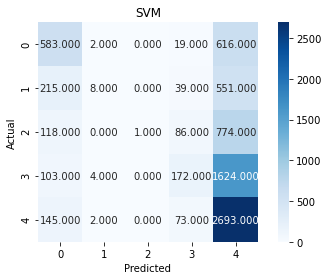

In [69]:
#Svm for float dataset
#Try to find the best kernel
classifier = SVC(kernel = 'linear')
classifier.fit(SVM_x_train_scaled,SVM_y_train.values.ravel())
SVM_y_pred = classifier.predict(SVM_x_val_scaled)

conf_matrix = metrics.confusion_matrix(SVM_y_val,SVM_y_pred) 
sns.heatmap(conf_matrix,annot=True,fmt=".3f",square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SVM') 
plt.tight_layout()

In [70]:
accuracy = metrics.accuracy_score(SVM_y_val,SVM_y_pred)
error = 1 - accuracy
precision = metrics.precision_score(SVM_y_val,SVM_y_pred,average = None)
recall = metrics.recall_score(SVM_y_val,SVM_y_pred,average=None)
F1_score = metrics.f1_score(SVM_y_val,SVM_y_pred,average = None)
print(["accuracy:",accuracy,"error:",error, "precision:", precision,"recall:",recall,"F1_score",F1_score])

['accuracy:', 0.4416198262646909, 'error:', 0.5583801737353091, 'precision:', array([0.50085911, 0.5       , 1.        , 0.44215938, 0.43032918]), 'recall:', array([0.47786885, 0.0098401 , 0.00102145, 0.0903836 , 0.92447648]), 'F1_score', array([0.48909396, 0.01930036, 0.00204082, 0.15008726, 0.58728601])]


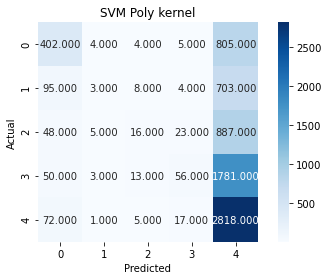

In [71]:
classifier = SVC(kernel = 'poly')
classifier.fit(SVM_x_train_scaled,SVM_y_train.values.ravel())
SVM_y_pred = classifier.predict(SVM_x_val_scaled)
conf_matrix = metrics.confusion_matrix(SVM_y_val,SVM_y_pred)
sns.heatmap(conf_matrix,annot=True,fmt=".3f",square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SVM Poly kernel')
plt.tight_layout()

In [72]:
accuracy = metrics.accuracy_score(SVM_y_val,SVM_y_pred)
error = 1 - accuracy
precision = metrics.precision_score(SVM_y_val,SVM_y_pred,average = None)
recall = metrics.recall_score(SVM_y_val,SVM_y_pred,average=None)
F1_score = metrics.f1_score(SVM_y_val,SVM_y_pred,average = None)
print(["accuracy:",accuracy,"error:",error, "precision:", precision,"recall:",recall,"F1_score",F1_score])

['accuracy:', 0.42092488502810427, 'error:', 0.5790751149718958, 'precision:', array([0.60269865, 0.1875    , 0.34782609, 0.53333333, 0.40291679]), 'recall:', array([0.3295082 , 0.00369004, 0.01634321, 0.02942722, 0.96738757]), 'F1_score', array([0.42607313, 0.00723764, 0.03121951, 0.05577689, 0.56889068])]


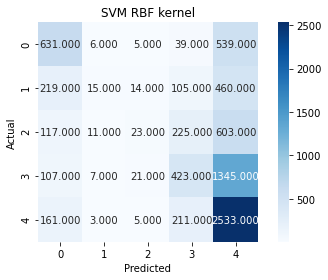

In [73]:
classifier = SVC(kernel = 'rbf')
classifier.fit(SVM_x_train_scaled,SVM_y_train.values.ravel())
SVM_y_pred = classifier.predict(SVM_x_val_scaled)
conf_matrix = metrics.confusion_matrix(SVM_y_val,SVM_y_pred)
sns.heatmap(conf_matrix,annot=True,fmt=".3f",square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SVM RBF kernel')
plt.tight_layout()

In [74]:
accuracy = metrics.accuracy_score(SVM_y_val,SVM_y_pred)
error = 1 - accuracy
precision = metrics.precision_score(SVM_y_val,SVM_y_pred,average = None)
recall = metrics.recall_score(SVM_y_val,SVM_y_pred,average=None)
F1_score = metrics.f1_score(SVM_y_val,SVM_y_pred,average = None)
print(["accuracy:",accuracy,"error:",error, "precision:", precision,"recall:",recall,"F1_score",F1_score])

['accuracy:', 0.4630812468063362, 'error:', 0.5369187531936638, 'precision:', array([0.51093117, 0.35714286, 0.33823529, 0.4217348 , 0.46222628]), 'recall:', array([0.51721311, 0.01845018, 0.02349336, 0.22228061, 0.86955029]), 'F1_score', array([0.51405295, 0.03508772, 0.04393505, 0.29112182, 0.60359824])]


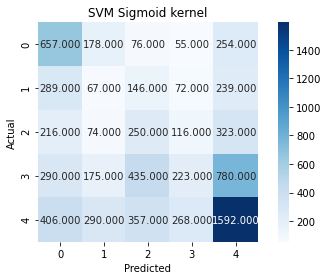

In [75]:
classifier = SVC(kernel = 'sigmoid')
classifier.fit(SVM_x_train_scaled,SVM_y_train.values.ravel())
SVM_y_pred = classifier.predict(SVM_x_val_scaled)
conf_matrix = metrics.confusion_matrix(SVM_y_val,SVM_y_pred)
sns.heatmap(conf_matrix,annot=True,fmt=".3f",square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SVM Sigmoid kernel')
plt.tight_layout()

In [76]:
accuracy = metrics.accuracy_score(SVM_y_val,SVM_y_pred)
error = 1 - accuracy
precision = metrics.precision_score(SVM_y_val,SVM_y_pred,average = None)
recall = metrics.recall_score(SVM_y_val,SVM_y_pred,average=None)
F1_score = metrics.f1_score(SVM_y_val,SVM_y_pred,average = None)
print(["accuracy:",accuracy,"error:",error, "precision:", precision,"recall:",recall,"F1_score",F1_score])

['accuracy:', 0.35628513030148184, 'error:', 0.6437148696985182, 'precision:', array([0.35360603, 0.08545918, 0.19778481, 0.30381471, 0.49937265]), 'recall:', array([0.53852459, 0.08241082, 0.25536261, 0.11718339, 0.54651562]), 'F1_score', array([0.42690058, 0.08390733, 0.22291574, 0.16913159, 0.52188166])]


In [79]:
rmse = np.sqrt(mean_squared_error(SVM_y_val, SVM_y_pred))
mae = mean_absolute_error(SVM_y_val, SVM_y_pred)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  1.8079764221288783
	mean_absolute_error =  1.2756770567194686


In [ ]:
#Implementation of the HinSAGE by changing the number of you can try increasing the number of training epochs,
#change the dropout rate, change the sample sizes for subgraph sampling num_samples, hidden layer sizes 
#layer_sizes of the HinSAGE part of the model, or try increasing the number of HinSAGE layers.

#Case 1
# Increase layer size


In [83]:
num_samples_2 = [8, 4]

In [84]:
hinsage_layer_sizes_2 = [52, 52]
assert len(hinsage_layer_sizes_2) == len(num_samples_2)

hinsage_2 = HinSAGE(
    layer_sizes=hinsage_layer_sizes_2, generator=generator, bias=True, dropout=0.0
)

In [87]:
x_inp_2, x_out_2 = hinsage_2.in_out_tensors()

In [88]:
score_prediction_2 = link_regression(edge_embedding_method="concat")(x_out_2)

link_regression: using 'concat' method to combine node embeddings into edge embeddings


In [98]:
model_2 = Model(inputs=x_inp_2, outputs=score_prediction_2)
model_2.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

In [99]:
model_2.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 8, 2)]       0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 32, 2)]      0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 32, 2)]      0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 1, 2)]       0                                            
____________________________________________________________________________________________

In [100]:
num_workers = 4

In [108]:
test_metrics_2 = model_2.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model_2.metrics_names, test_metrics_2):
    print("\t{}: {:0.4f}".format(name, val))

59/59 [==============================] - 5s 73ms/step - loss: 1.6912 - root_mean_square_error: 1.2997 - mean_absolute_error: 1.0607
Untrained model's Test Evaluation:
	loss: 1.6912
	root_mean_square_error: 1.2997
	mean_absolute_error: 1.0607


In [109]:
history_2 = model_2.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers,
)

Epoch 1/20
137/137 [==============================] - 16s 118ms/step - loss: 1.6888 - root_mean_square_error: 1.2983 - mean_absolute_error: 1.0649 - val_loss: 1.6857 - val_root_mean_square_error: 1.2975 - val_mean_absolute_error: 1.0608- mean_absolute_e - ETA: 5s - loss: 1.6818 - root_mean_square_error: 1.2957 - mean_absolute_e - ETA: 4s - loss: 1.6793 - root_mean_square_error: 1.2946 - mean_absolute_error: 1.06 - ETA: 4s - loss: 1.6793 - root_mean_square_err - ETA: 2s - loss: 1.6874 - root_mean_square_error: 1.2977 - mean_absolute_error: 1. - ETA: 2s - loss: 1.6901 - root_mean_square_error: 1.2988 -
Epoch 2/20
137/137 [==============================] - 14s 103ms/step - loss: 1.6886 - root_mean_square_error: 1.2980 - mean_absolute_error: 1.0620 - val_loss: 1.7278 - val_root_mean_square_error: 1.3139 - val_mean_absolute_error: 1.1214
Epoch 3/20
137/137 [==============================] - 17s 121ms/step - loss: 1.7081 - root_mean_square_error: 1.3056 - mean_absolute_error: 1.0739 - val_lo

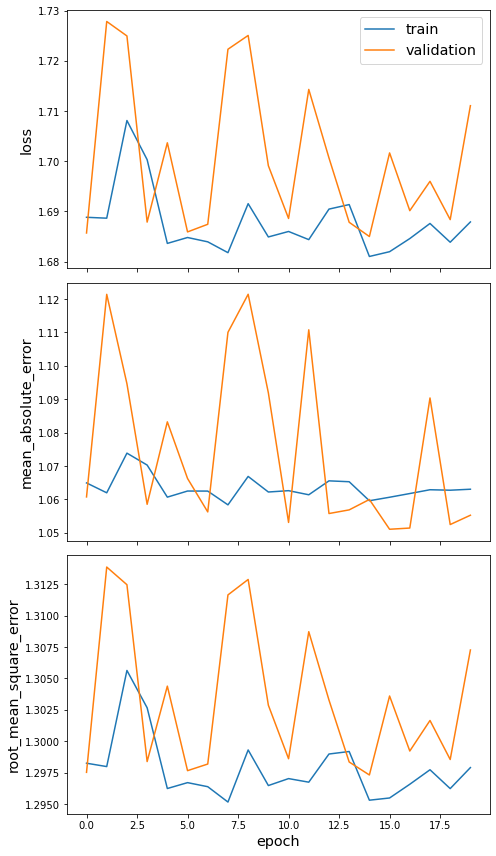

In [110]:
sg.utils.plot_history(history_2)

In [111]:
test_metrics_2 = model_2.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model_2.metrics_names, test_metrics_2):
    print("\t{}: {:0.4f}".format(name, val))

59/59 [==============================] - 4s 62ms/step - loss: 1.7106 - root_mean_square_error: 1.3071 - mean_absolute_error: 1.0548 4s - loss: 1.7112 - root_mean_square_error: 1.3077 - mean_ab - ETA: 2s - loss: 1.6866 - root_mean_square_error: 1.29
Test Evaluation:
	loss: 1.7106
	root_mean_square_error: 1.3071
	mean_absolute_error: 1.0548


In [197]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model_2.predict(test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  1.463703040241648
	mean_absolute_error =  1.2744868861169023

Model Test set metrics:
	root_mean_square_error =  1.3078420150094225
	mean_absolute_error =  1.055087144909675


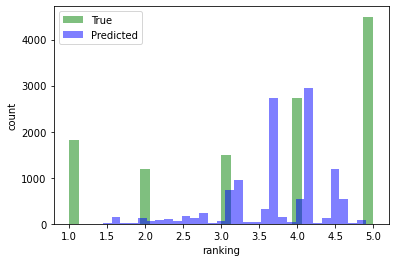

In [198]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()

In [ ]:
# Case 2

#Case 1
#1 increase epochs
#2 change dropout rate
#3 change num_samples,hidden layer sizer(layer_sizes)

In [164]:
epochs_3 = 30

In [165]:
num_samples_3 = [12, 8]

In [177]:
generator_3 = HinSAGELinkGenerator(
    G, batch_size, num_samples_3, head_node_types=["business", "user"]
)
train_gen_3 = generator_3.flow(edgelist_train, labels_train, shuffle=True)
test_gen_3 = generator_3.flow(edgelist_test, labels_test)

In [178]:
generator_3.schema.type_adjacency_list(generator_3.head_node_types, len(num_samples_3))

[('business', [2]),
 ('user', [3]),
 ('user', [4]),
 ('business', [5]),
 ('business', []),
 ('user', [])]

In [179]:
generator_3.schema.schema

{'user': [EdgeType(n1='user', rel='default', n2='business')],
 'business': [EdgeType(n1='business', rel='default', n2='user')]}

In [180]:
hinsage_layer_sizes_3 = [52, 52]
assert len(hinsage_layer_sizes_3) == len(num_samples_3)

hinsage_3 = HinSAGE(
    layer_sizes=hinsage_layer_sizes_3, generator=generator_3, bias=True, dropout=0.2
)

In [181]:
x_inp_3, x_out_3 = hinsage_3.in_out_tensors()

In [182]:
score_prediction_3 = link_regression(edge_embedding_method="concat")(x_out_3)

link_regression: using 'concat' method to combine node embeddings into edge embeddings


In [183]:
model_3 = Model(inputs=x_inp_3, outputs=score_prediction_3)
model_3.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

In [184]:
model_3.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           [(None, 12, 2)]      0                                            
__________________________________________________________________________________________________
input_53 (InputLayer)           [(None, 96, 2)]      0                                            
__________________________________________________________________________________________________
input_54 (InputLayer)           [(None, 96, 2)]      0                                            
__________________________________________________________________________________________________
input_49 (InputLayer)           [(None, 1, 2)]       0                                            
___________________________________________________________________________________________

In [185]:
num_workers_3 = 4

In [187]:
test_metrics_3 = model_3.evaluate(
    test_gen_3, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model_3.metrics_names, test_metrics_3):
    print("\t{}: {:0.4f}".format(name, val))

59/59 [==============================] - 13s 181ms/step - loss: 15.1598 - root_mean_square_error: 3.8915 - mean_absolute_error: 3.60639s - loss: 15.2225 - root_mean_square_error: 3.9006 -  - ETA: 3s - loss: 15.1778 - root_mean_square_error: 3.8948 - mean_absolute_error
Untrained model's Test Evaluation:
	loss: 15.1598
	root_mean_square_error: 3.8915
	mean_absolute_error: 3.6063


In [191]:
history_3 = model_3.fit(
    train_gen_3,
    validation_data=test_gen_3,
    epochs=epochs_3,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers_3,
)

Epoch 1/30
137/137 [==============================] - 47s 339ms/step - loss: 1.7917 - root_mean_square_error: 1.3374 - mean_absolute_error: 1.1131 - val_loss: 1.7871 - val_root_mean_square_error: 1.3364 - val_mean_absolute_error: 1.1456: 1.7685 - root_mean_square_error: 1.3284 - mean_abso - ETA: 28s - loss: 1.7721 - root_mean_square_error: 1.3298 - mean_absolute_error - ETA: 26s - loss: 1.7534 - root_mean_square_error: 1.3228 - mean_absolute_er - ETA: 22s - loss: 1.7670 - root_mean_square_error: 1.3279 - mean_absolute_e - ETA: 18s - loss: 1.7828 - root_mean_square_error: 1.3338 - mean_abso - ETA: 13s - loss: 1.7944 - root_mean_square_error - ETA: 7s - loss: 1.7866 - root_mean_square_error:  - ETA: 3s - loss: 1.7910 - root_mean_square_error: 1.3371 - mean_absolute_error:  - ETA: 2s - loss: 1.7921 - root_mean_square_error: 1.3375 - mean_absolute_error
Epoch 2/30
137/137 [==============================] - 50s 357ms/step - loss: 1.7811 - root_mean_square_error: 1.3333 - mean_absolute_error

137/137 [==============================] - 55s 396ms/step - loss: 1.7682 - root_mean_square_error: 1.3282 - mean_absolute_error: 1.1020 - val_loss: 1.9613 - val_root_mean_square_error: 1.4000 - val_mean_absolute_error: 1.2421 - loss: 1.7061 - root_mean_square_error: 1.3049 - mean_absolute_error - ETA: 33s - loss: 1.7070 - root_mean_square_error: 1.3048 - mean_absolute_error: 1.08 - ETA: 41s - loss: 1.7122 - root_mean_square_error: 1.3067 - mean_absolute_error: 1.08 - ETA: 41s - loss: 1.7241 - root_mean_square_error: 1.3112 - mean_absolute_error: 1.085 - ETA: 41s - loss: 1.7289 - root_mean_square_error: 1.3130 - mean_absolute_error - ETA: 39s - loss: 1.7600 - root_mean_square_error: 1.3245 - mean_absolute_ - ETA: 31s - loss: 1.7541 - root_mean_square_error: 1.3225 - mean_absolute_e - ETA: 26s - loss: 1.7686 - root_mean_square_error: 1.3279 - mean_absolut - ETA: 20s - loss: 1.7648 - root_mean_square_error: 1.3265 - mean_absolute_err - ETA: 16s - loss: 1.7679 - root_mean_square_error: 1.3

137/137 [==============================] - 62s 450ms/step - loss: 1.7621 - root_mean_square_error: 1.3261 - mean_absolute_error: 1.1014 - val_loss: 1.7814 - val_root_mean_square_error: 1.3342 - val_mean_absolute_error: 1.1480- root_mean_square_error: 1.3478 - mean_absolute_error:  - ETA: 41s - loss: 1.7927 - root_mean_square_error: 1.3380 - mea - ETA: 27s - loss: 1.7591 - root_mean_square_error: 1.3253 - mean_absolute - ETA: 22s - loss: 1.7694 - root_mean_square_error: 1.3288 - mean_absolute_error: - ETA: 19s - loss: 1.7765 - root_mean_square_error: 1.3316 - mean_absolute_e - ETA: 16s - loss: 1.7798 - root_mean_square_error: 1.3327 - mean_absolute_error: 1. - ETA: 15s - loss: 1.7776 - root_mean_square_error: 1.3318 - mean_absolute_error: 1.1 - ETA: 14s - loss: 1.7765 - root_mean_ - ETA: 4s - loss: 1.7605 - root_mean_square_error: 1.3254 - mean_absolute_error: 1. - ETA: 3s - loss: 1.7615 - root_mean_square_error: 1.3258 - mean_absolute_error
Epoch 17/30
137/137 [========================

137/137 [==============================] - 102s 734ms/step - loss: 1.7540 - root_mean_square_error: 1.3232 - mean_absolute_error: 1.0960 - val_loss: 1.9322 - val_root_mean_square_error: 1.3896 - val_mean_absolute_error: 1.2295: 1.7653 - root_mean_sq - ETA: 17s - loss: 1.7544 - roo


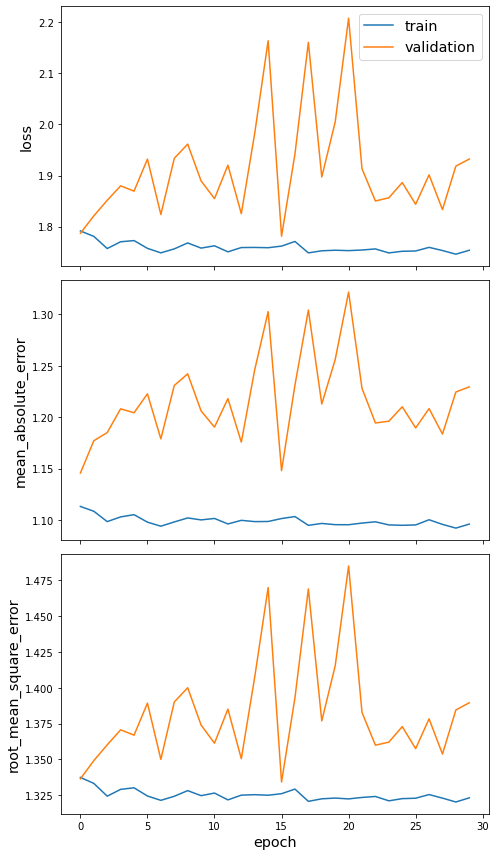

In [192]:
sg.utils.plot_history(history_3)

In [193]:
test_metrics_3 = model_3.evaluate(
    test_gen_3, use_multiprocessing=False, workers=num_workers_3, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model_3.metrics_names, test_metrics_3):
    print("\t{}: {:0.4f}".format(name, val))

59/59 [==============================] - 30s 474ms/step - loss: 1.9260 - root_mean_square_error: 1.3872 - mean_absolute_error: 1.2279 20s - loss: 1.9164 - root_mean_square_error: 1.3838 - mean_absolute_error: 1 - ETA: 17s - loss: 1.9039 - root_mean_square_error: 1.379 - ETA: 6s - loss: 1.9166 - root_mean_square_error: 1.3838 - mean_absolute_err - ETA: 3s - loss: 1.9187 - root_mean_square_error: 1.3846 - mean_absolu
Test Evaluation:
	loss: 1.9260
	root_mean_square_error: 1.3872
	mean_absolute_error: 1.2279


In [195]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model_3.predict(test_gen_3)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  1.463703040241648
	mean_absolute_error =  1.2744868861169023

Model Test set metrics:
	root_mean_square_error =  1.3889977961737274
	mean_absolute_error =  1.2291692468848348


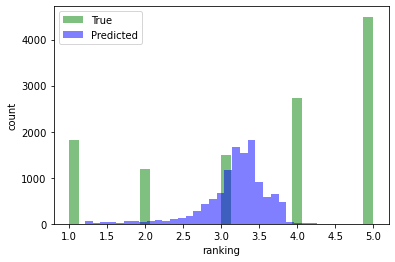

In [196]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()